# Random Forest (Regression)
This document is another attempt at applying the Random Forest model for time prediction using regression. It doesn't use the self-made implementation of Random Forest but a library one to speed up the process and make sure the model has been implemented correctly.

In [22]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
from IPython.display import display

In [23]:
# Config variables
training_data_path = '../../datasets/bpi_2012_train_eng.csv'
testing_data_path = '../../datasets/bpi_2012_test_eng.csv'

n_samples = 2000
n_trees = 5
sample_split = 5
max_depth = 5


# 1. Loading and preparing the data

In [24]:
# Loading and splitting the datasets
df_train = pd.read_csv(training_data_path)
df_train = df_train.set_index('event_index').drop('Unnamed: 0', axis=1)
df_train = df_train.dropna()

df_test = pd.read_csv(testing_data_path)
df_test = df_test.set_index('event_index').drop('Unnamed: 0', axis=1)
df_test = df_test.dropna()


In [25]:
# Make dummy variables from the event type for modelling purposes
event_dummies_train = pd.get_dummies(df_train['event'])
next_event_dummies_train = pd.get_dummies(df_train['nextEvent'])
event_dummies_train = event_dummies_train.join(next_event_dummies_train, lsuffix="_e", rsuffix=("_ne"))

event_dummies_test = pd.get_dummies(df_test['event'])
next_event_dummies_test = pd.get_dummies(df_test['nextEvent'])
event_dummies_test = event_dummies_test.join(next_event_dummies_test, lsuffix="_e", rsuffix=("_ne"))

# Put the dummy variables back in the dataframe as columns
df_train_dummies = pd.concat([df_train, event_dummies_train], axis=1)
df_test_dummies = pd.concat([df_test, event_dummies_test], axis=1)


# Sub-select rows based on prefixes (WIP, only a test)
df_train_dummies = df_train_dummies[df_train_dummies['nextEvent'].str[0] == 'O']
df_test_dummies = df_test_dummies[df_test_dummies['nextEvent'].str[0] == 'O']


df_train_dummies.drop(['event', 'nextEvent', 'W_Valideren aanvraag_e', 'W_Valideren aanvraag_ne'], axis=1, inplace=True)
df_test_dummies.drop(['event', 'nextEvent', 'W_Valideren aanvraag_e', 'W_Valideren aanvraag_ne'], axis=1, inplace=True)

# Drop the features the model doesn't use
X_train = df_train_dummies.drop(columns=['startTime', 'completeTime', 'REG_DATE', 'case', 'AMOUNT_REQ', 'org:resource', 'nextEventTime', 'nextEventTimeRel'])
X_test = df_test_dummies.drop(columns=['startTime', 'completeTime', 'REG_DATE', 'case', 'AMOUNT_REQ', 'org:resource', 'nextEventTime', 'nextEventTimeRel'])

# Construct the output parameters with from the training and testing sets with the correct rows dropped
Y_train = df_train_dummies['nextEventTimeRel']
Y_test = df_test_dummies['nextEventTimeRel']

X_train.head()


,startTimeRel,indexInCase,dayOfWeek,dayOfMonth,A_ACCEPTED_e,A_ACTIVATED_e,A_APPROVED_e,A_CANCELLED_e,A_DECLINED_e,A_FINALIZED_e,...,O_CREATED_ne,O_DECLINED_ne,O_SELECTED_ne,O_SENT_ne,O_SENT_BACK_ne,W_Afhandelen leads_ne,W_Beoordelen fraude_ne,W_Completeren aanvraag_ne,W_Nabellen incomplete dossiers_ne,W_Nabellen offertes_ne
event_index,,,,,,,,,,,,,,,,,,,,,
20727,7330,5,1,18,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
26832,71541,6,0,24,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
38154,184811,13,4,4,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
83625,1096843,11,0,19,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
87976,142592,7,0,12,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# 2. Training the model and making the predictions

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time

start_time = time.time()

rfr = RandomForestRegressor(random_state=42, max_depth=12, min_samples_split=4)
rfr.fit(X_train, Y_train)

# Predicting the values of our test dataset
rfr_pred = rfr.predict(X_test)

rmse = np.sqrt(mean_squared_error(Y_test, rfr_pred))

# Retrieving the accuracy of the model
print(f'RMSE score: {rmse}')

# Ending time
end_time = time.time()
print(f'\r\nThe execution of Random Forest (Regression) took {round(end_time - start_time)} seconds')


RMSE score: 434605.1766052094

The execution of Random Forest (Regression) took 8 seconds


Elapsed time to compute the importances: 0.032 seconds


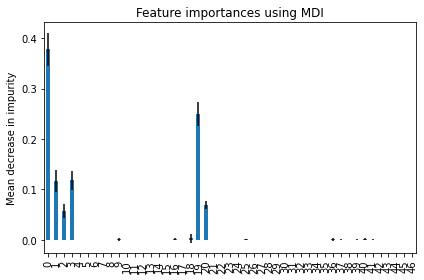

In [27]:
start_time = time.time()
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

import pandas as pd

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [28]:
# Extract single tree
#estimator = rfr.estimators_[5]

#from sklearn.tree import export_graphviz
# Export as dot file
#export_graphviz(estimator, out_file='tree.dot', rounded = True, proportion = False, precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')